In [30]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

X = pd.read_csv("../data/train.csv", index_col='Id')
test_data= pd.read_csv("../data/test.csv", index_col='Id')

In [31]:
X.dropna(axis=0, subset=['SalePrice'], inplace=True)
y=X.SalePrice
X.drop(['SalePrice','Alley','MasVnrType','FireplaceQu','PoolQC','Fence','MiscFeature'], axis=1, inplace=True)

# spliting the data into train and test
X_train_full,X_valid_full,y_train,y_valid = train_test_split(X,y,train_size=0.8,test_size=0.2,random_state=0)

categorial_cols = [cols for cols in X_train_full.columns if X_train_full[cols].nunique() < 10 and X_train_full[cols].dtype == 'object']
numerical_cols = [cols for cols in X_train_full.columns if X_train_full[cols].dtype in ['int64','float64']]
cols = categorial_cols + numerical_cols
X_train = X_train_full[cols].copy()
X_valid = X_valid_full[cols].copy()
X_test = test_data[cols].copy()

X_train = pd.get_dummies(X_train)
X_valid = pd.get_dummies(X_valid)
X_test = pd.get_dummies(X_test)
X_train, X_valid = X_train.align(X_valid, join='left', axis=1)
X_train, X_test = X_train.align(X_test, join='left', axis=1)

# Preprocessing the data for numerical values and Categorial values
using Simpleimputer and OneHotEncoder with the help of pipeline and transfromer

In [32]:
numerical_transformer = SimpleImputer(strategy='median')
categorial_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('OneHotEncoder', OneHotEncoder(handle_unknown='ignore'))
])
# making a preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorial_transformer, categorial_cols)
])

# finetuning n_estimators

In [33]:
def get_score(n_estimators):
    my_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', XGBRegressor(n_estimators=n_estimators, learning_rate=0.05, max_depth=5))
    ])
    score = -1 * cross_val_score(my_pipeline, X, y, cv=5, scoring='neg_mean_absolute_error')
    return score.mean()

In [34]:
result = {}
for i in range(1,11):
    result[100*i] = get_score(100*i)

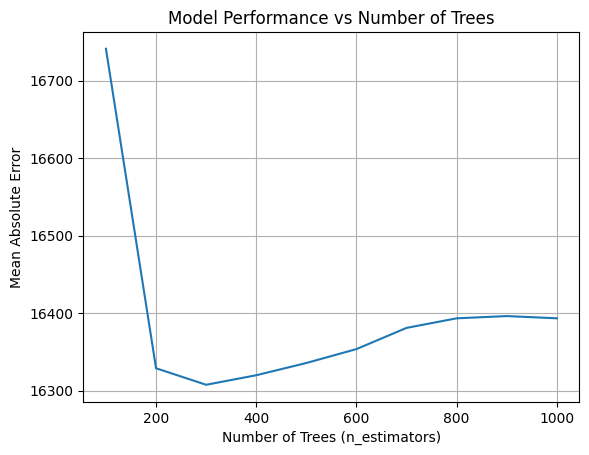

Best n_estimators: 300


In [35]:
# Ploting the graph of Model performance vs Number of trees(n_estimators)
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(list(result.keys()), list(result.values()))
plt.title("Model Performance vs Number of Trees")
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Mean Absolute Error")
plt.grid(True)
plt.show()
best_n = min(result, key=result.get) 
print(f"Best n_estimators: {best_n}")

# Finetuning learning_rate

In [36]:
import numpy as np
learning_rates = np.linspace(0.01, 0.2, 70)  
results = {}

for lr in learning_rates:
    model = XGBRegressor(n_estimators=best_n, learning_rate=lr, early_stopping_rounds=5)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
    
    preds = model.predict(X_valid)
    mae = mean_absolute_error(y_valid, preds)
    results[lr] = mae

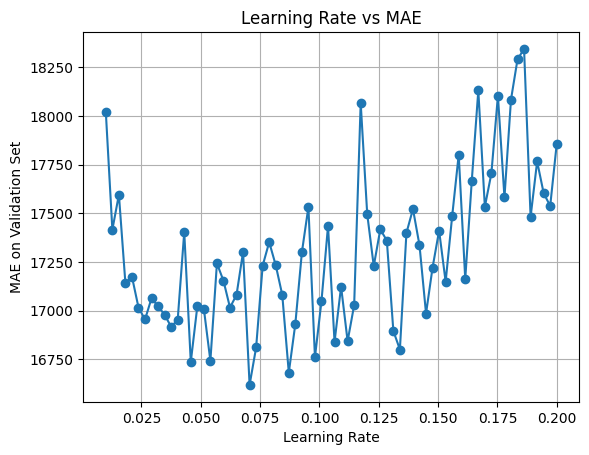

Best learning rate: 0.07057971014492753


In [37]:
plt.plot(results.keys(), results.values(), marker='o')
plt.xlabel("Learning Rate")
plt.ylabel("MAE on Validation Set")
plt.title("Learning Rate vs MAE")
plt.grid(True)
plt.show()

best_lr = min(results, key=results.get)
print(f"Best learning rate: {best_lr}")

# Defining and training our model

In [38]:
my_model = XGBRegressor(n_estimators=best_n, learning_rate = best_lr, early_stopping_rounds=5)

# Fit with early stopping
my_model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    verbose=2
)

[0]	validation_0-rmse:78532.00083
[2]	validation_0-rmse:71376.47077
[4]	validation_0-rmse:65255.35653
[6]	validation_0-rmse:60428.00772
[8]	validation_0-rmse:56077.09193
[10]	validation_0-rmse:52014.38979
[12]	validation_0-rmse:48002.24796
[14]	validation_0-rmse:45472.28809
[16]	validation_0-rmse:43511.20278
[18]	validation_0-rmse:41784.21188
[20]	validation_0-rmse:40161.06181
[22]	validation_0-rmse:39183.48620
[24]	validation_0-rmse:38303.75170
[26]	validation_0-rmse:37410.47855
[28]	validation_0-rmse:36653.70167
[30]	validation_0-rmse:35892.94280
[32]	validation_0-rmse:35291.21952
[34]	validation_0-rmse:34843.20327
[36]	validation_0-rmse:34684.09147
[38]	validation_0-rmse:34547.31304
[40]	validation_0-rmse:34459.69926
[42]	validation_0-rmse:34139.51132
[44]	validation_0-rmse:34029.93025
[46]	validation_0-rmse:33827.97103
[48]	validation_0-rmse:33638.68499
[50]	validation_0-rmse:33603.92887
[52]	validation_0-rmse:33566.98132
[54]	validation_0-rmse:33414.24590
[56]	validation_0-rmse:33

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,5
,enable_categorical,False
,eval_metric,None


In [42]:
pred = my_model.predict(X_valid)
mea = mean_absolute_error(y_valid, pred)
print(mea) # 16683.958984375

16618.408203125


# For testing the model on test.csv and storing the output in a csv file

In [ ]:
#predictions = my_model.predict(X_test)
#output = pd.DataFrame({'Id': test_data.index, 'SalePrice': predictions})
#output.to_csv('submission.csv', index=False)